## IMPLEMENTING A GPT MODEL FROM SCRATCH TO GENERATE TEXT

In [6]:
GPT_CONFIG_124M = {
    "vocab_size": 50257, # Vocabulary size
    "context_length": 1024, # Context length
    "emb_dim": 768,  # Embedding dimension
    "n_heads": 12,   # Number of attention heads
    "n_layers":12,   # Number of layers
    "drop_rate": 0.1, # Dropout rate
    "qkv_bias": False  # Query-Key-Value bias
}



## GPT ARCHITECTURE PART 1 : DUMMY GPT MODEL CLASS

<div class="alert alert-block alert-info"> 
Step 1: Use a placeholder for Transformer Block

Step 2: Use a placeholder for LayerNorm
</div>



In [7]:
import torch
import torch.nn as nn

class DummyGPTModel(nn.Module):
    def __init__(self,cfg):
        super().__init__()
        self.tok_emb = nn.Embedding(cfg["vocab_size"],cfg["emb_dim"])
        self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"])
        self.drop_emb = nn.Dropout(cfg["drop_rate"])

        # Use a placeholder for Transformer Block

        self.trf_blocks = nn.Sequential(
            *[DummyTransformerBlock(cfg) for _ in range(cfg["n_layers"]) ]
        )

        # Use a placeholdr for LayerNorm
        
        self.final_norm = DummyLayerNorm(cfg["emb_dim"])
        self.out_head = nn.Linear(
            cfg["emb_dim"], cfg["vocab_size"], bias=False
        )


        

    def forward(self,in_idx):
        batch_size, seq_len = in_idx.shape
        tok_embeds = self.tok_emb(in_idx)
        pos_embeds = self.pos_emb(torch.arange(seq_len, device=in_idx.device))
        x = tok_embeds + pos_embeds
        x = self.drop_emb(x)
        x = self.trf_blocks(x)
        x = self.final_norm(x)
        logits = self.out_head(x)
        return logits
    



class DummyTransformerBlock(nn.Module):
    def __init__(self,cfg):
        super().__init__()
        # A simple placeholder

    def forward(self,x):
        # This block does nothing and just returns its input.
        return x 
    

class DummyLayerNorm(nn.Module):
    def __init__(self,normalized_shape,eps=1e-5):
        super().__init__()
        # The parameters here are just to mimic the LayerNorm interface.

    def forward(self,x):
        # This  layer does nothing and  just returns its input.
        return x 
    



In [8]:
import tiktoken
tokenizer = tiktoken.get_encoding("gpt2")
batch = []
txt1 = "Every efforts moves you"
txt2 = "Every day holds a"
batch.append(torch.tensor(tokenizer.encode(txt1)))
batch.append(torch.tensor(tokenizer.encode(txt2)))
batch = torch.stack(batch,dim=0)
print(batch)


tensor([[6109, 4040, 6100,  345],
        [6109, 1110, 6622,  257]])


## STEP 2 : CREATE AN INSTANCE OF DUMMY GPT MODEL

In [9]:
torch.manual_seed(123)
model = DummyGPTModel(GPT_CONFIG_124M)
logits = model(batch)
print("Output shape:",logits.shape)
print(logits)

Output shape: torch.Size([2, 4, 50257])
tensor([[[-0.9289,  0.2748, -0.7557,  ..., -1.6070,  0.2702, -0.5888],
         [-0.8606,  1.3502, -0.2798,  ..., -0.6376,  1.4690,  1.2530],
         [ 0.5680,  1.6053, -0.2155,  ...,  1.1624,  0.1380,  0.7425],
         [ 0.0447,  2.4787, -0.8843,  ...,  1.3219, -0.0864, -0.5856]],

        [[-1.5474, -0.0542, -1.0571,  ..., -1.8061, -0.4494, -0.6747],
         [-0.8422,  0.8243, -0.1098,  ..., -0.1434,  0.2079,  1.2046],
         [ 0.1355,  1.1858, -0.1453,  ...,  0.0869, -0.1590,  0.1552],
         [ 0.1666, -0.8138,  0.2307,  ...,  2.5035, -0.3055, -0.3083]]],
       grad_fn=<UnsafeViewBackward0>)


## GPT ARCHITECTURE PART 2 : LAYER NORMALIZATON

#### Explanation with a simple example

In [10]:
torch.manual_seed(123)
batch_example = torch.randn(2,5) #A
layer = nn.Sequential(nn.Linear(5,6),nn.ReLU())
out = layer(batch_example)
print(out)

tensor([[0.2260, 0.3470, 0.0000, 0.2216, 0.0000, 0.0000],
        [0.2133, 0.2394, 0.0000, 0.5198, 0.3297, 0.0000]],
       grad_fn=<ReluBackward0>)


<div class="alert alert-block alert-info">
The neural network layer we have coded consists of a Linear layer followed by a non-linear activation function (RELU). 
 </div>



<div class="alert alert-block alert-success">
Before we apply layer normalization to these outputs, let's examine the mean and variance:
 </div>



In [11]:
mean = out.mean(dim=-1,keepdim=True)
var = out.var(dim=-1,keepdim=True)
print("Mean:\n",mean)
print("Variance:\n",var)

Mean:
 tensor([[0.1324],
        [0.2170]], grad_fn=<MeanBackward1>)
Variance:
 tensor([[0.0231],
        [0.0398]], grad_fn=<VarBackward0>)


<div class="alert alert-block alert-warning">
The first row in the mean tensor above contains the mean value for the first input row, and the second output row contains the mean for the second input row.
 </div>



In [12]:
out_norm = ( out - mean)/ torch.sqrt(var)
mean = out_norm.mean(dim=-1,keepdim=True)
var = out_norm.var(dim=-1,keepdim=True)
print("Normalized layer outputts:\n",out_norm)
print("Mean:\n",mean)
print("Variance:\n",var)

Normalized layer outputts:
 tensor([[ 0.6159,  1.4126, -0.8719,  0.5872, -0.8719, -0.8719],
        [-0.0189,  0.1121, -1.0876,  1.5173,  0.5647, -1.0876]],
       grad_fn=<DivBackward0>)
Mean:
 tensor([[9.9341e-09],
        [5.9605e-08]], grad_fn=<MeanBackward1>)
Variance:
 tensor([[1.0000],
        [1.0000]], grad_fn=<VarBackward0>)


In [13]:
torch.set_printoptions(sci_mode=False)
print("Mean:\n",mean)
print("Variance:\n",var)

Mean:
 tensor([[    0.0000],
        [    0.0000]], grad_fn=<MeanBackward1>)
Variance:
 tensor([[1.0000],
        [1.0000]], grad_fn=<VarBackward0>)


In [14]:
# LayerNorm implementation
class LayerNorm(nn.Module):
    def __init__(self, emb_dim):
        super().__init__()
        self.eps = 1e-5
        self.scale = nn.Parameter(torch.ones(emb_dim))
        self.shift = nn.Parameter(torch.zeros(emb_dim))

    def forward(self, x):
        mean = x.mean(dim=-1, keepdim=True)
        var = x.var(dim=-1, keepdim=True, unbiased=False)
        norm_x = (x - mean) / torch.sqrt(var + self.eps)
        return self.scale * norm_x + self.shift

<div class="alert alert-block alert-success">
Let's now try the LayerNorm module in practice and apply it to the batch input:
</div>

In [15]:
ln = LayerNorm(emb_dim=5)
out_ln = ln(batch_example)
mean = out_ln.mean(dim=-1,keepdim=True)
var = out_ln.var(dim=-1,unbiased=False,keepdim=True)
print("Mean:\n",mean)
print("Variance:\n",var)

Mean:
 tensor([[    -0.0000],
        [     0.0000]], grad_fn=<MeanBackward1>)
Variance:
 tensor([[1.0000],
        [1.0000]], grad_fn=<VarBackward0>)


## ARCHITECTURE PART 3 : FEEDFORWARD NEURAL NETWORK WITH GELU ACTIVATION

<div class="alert alert-block alert-success">
Let's implement the GELU activation function approximation used by GPT-2:
</div>

In [16]:
class GELU(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self,x):
        return 0.5*x*(1 + torch.tanh(
            torch.sqrt(torch.tensor(2.0/torch.pi))*
            (x+ 0.044715*torch.pow(x,3))
        ))

<div class="alert alert-block alert-success">
To get an idea of what this  GELU function looks like and how it compares to the ReLu function, let's plot these functions side by side:
</div>

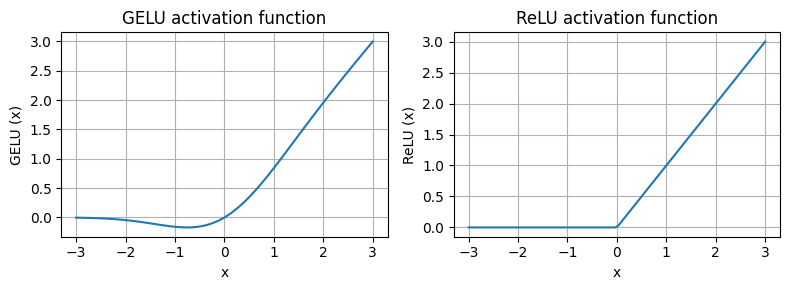

In [17]:
import matplotlib.pyplot as plt

gelu, relu = GELU(), nn.ReLU()

# Some sample data
x = torch.linspace(-3,3,100)
y_gelu, y_relu = gelu(x), relu(x)

plt.figure(figsize=(8,3))
for i, (y,label) in enumerate(zip([y_gelu,y_relu],['GELU',"ReLU"]),1):
    plt.subplot(1,2,i)
    plt.plot(x,y)
    plt.title(f"{label} activation function")
    plt.xlabel("x")
    plt.ylabel(f"{label} (x)")
    plt.grid(True)

plt.tight_layout()
plt.show()


In [18]:
class FeedForward(nn.Module):
    def __init__(self,cfg):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(cfg["emb_dim"],4* cfg["emb_dim"]), ## Expansion
            GELU(),  ## Activation
            nn.Linear(4*cfg["emb_dim"],cfg["emb_dim"]), ## Contraction
        )

    def forward(self,x):
        return self.layers(x)

In [19]:
print(GPT_CONFIG_124M["emb_dim"])

768


In [20]:
ffn = FeedForward(GPT_CONFIG_124M)
x = torch.rand(2,3,768) #A
out = ffn(x)
print(out.shape)

torch.Size([2, 3, 768])


## GPT ARCHITECTURE PART 4: SHORTCUT CONNECTIONS

<div class="alert alert-block alert-success">
Let us see how we can add shortcut connections to the forward method:
</div>

In [21]:
class ExampleDeepNeuralNetwork(nn.Module):
    def __init__(self,layer_sizes,use_shortcut):
        super().__init__()
        self.use_shortcut = use_shortcut
        self.layers = nn.ModuleList(
            [
                nn.Sequential(nn.Linear(layer_sizes[0],layer_sizes[1]),GELU()),
                nn.Sequential(nn.Linear(layer_sizes[1],layer_sizes[2]),GELU()),
                nn.Sequential(nn.Linear(layer_sizes[2],layer_sizes[3]),GELU()),
                nn.Sequential(nn.Linear(layer_sizes[3],layer_sizes[4]),GELU()),
                nn.Sequential(nn.Linear(layer_sizes[4],layer_sizes[5]),GELU()),

            ]
        )

    def forward(self,x):
        for layer in self.layers:
            # Compute the output of the current layer
            layer_output  = layer(x)
            # Check if shortcut can be applied
            if self.use_shortcut and x.shape == layer_output.shape:
                x = x + layer_output
            else:
                x = layer_output
        return x



In [22]:
layer_sizes = [3,3,3,3,3,1]
sample_input = torch.tensor([[1.,0.,-1.]])
torch.manual_seed(123) # specify random seed for the initial weights 
model_without_shortcut = ExampleDeepNeuralNetwork(
    layer_sizes,use_shortcut=False
)

<div class="alert alert-block alert-success">
Next, we implement a function that computes the gradients in the model's backward pass:
</div>

In [23]:
def print_gradients(model,x):
    # Forward pass
    output = model(x)
    target = torch.tensor([[0.]])

    # Calcuate loss based on how close the target  and output are
    loss = nn.MSELoss()
    loss = loss(output,target)

    # Backward pass to calculate the gradients
    loss.backward()

    for name, param in model.named_parameters():
        if "weight" in name:
            # Print the mean absolute gradient of the weights
            print(f"{name} has gradient mean of {param.grad.abs().mean().item()}")
            


In [24]:
print_gradients(model_without_shortcut,sample_input)

layers.0.0.weight has gradient mean of 0.00020173590746708214
layers.1.0.weight has gradient mean of 0.0001201116101583466
layers.2.0.weight has gradient mean of 0.0007152042235247791
layers.3.0.weight has gradient mean of 0.0013988739810883999
layers.4.0.weight has gradient mean of 0.00504964729771018


<div class="alert alert-block alert-success">
Let's now instantiate a model with skip connections and see how it comparees:
</div>

In [25]:
torch.manual_seed(123)
model_without_shortcut = ExampleDeepNeuralNetwork(
    layer_sizes,use_shortcut=True 
)
print_gradients(model_without_shortcut,sample_input)

layers.0.0.weight has gradient mean of 0.22169791162014008
layers.1.0.weight has gradient mean of 0.20694102346897125
layers.2.0.weight has gradient mean of 0.32896995544433594
layers.3.0.weight has gradient mean of 0.2665732204914093
layers.4.0.weight has gradient mean of 1.3258541822433472


## GPT ARCHITECTURE  PART 5: CODING ATTENTION AND LINEAR LAYERS IN A TRANSFORMER BLOCK

In [26]:
GPT_CONFIG_124M = {
    "vocab_size": 50257,      # Vocabulary size
    "context_length": 1024,   # Context length
    "emb_dim": 768,           # Embedding dimension
    "n_heads": 12,            # Number of attention heads
    "n_layers": 12,           # Number of layers
    "drop_rate": 0.1,         # Dropout rate
    "qkv_bias": False         # Query-Key-Value bias
}

### THE BUILDING BLOCKS: LAYER NORMALIZATION, GELU AND FEED-FORWARD NEURALNETWORK

In [27]:
class LayerNorm(nn.Module):
    def __init__(self,emb_dim):
        super().__init__()
        self.eps = 1e-5
        self.scale = nn.Parameter(torch.ones(emb_dim))
        self.shift = nn.Parameter(torch.zeros(emb_dim))

    def forward(self,x):
        mean = x.mean(dim=-1,keepdim=True)
        var = x.var(dim=-1,keepdim=True,unbiased=False)
        norm_x = (x - mean)/ torch.sqrt(var + self.eps)
        return self.scale * norm_x + self.shift



class GELU(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self,x):
        return 0.5*x*(1+torch.tanh(
            torch.sqrt(torch.tensor(2.0/torch.pi))*
            (x + 0.044715*torch.pow(x,3))

        ))

class FeedForward(nn.Module):
    def __init__(self,cfg):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(cfg["emb_dim"],4*cfg["emb_dim"]), ## Expansion
            GELU(), ## Activation
            nn.Linear(4*cfg["emb_dim"],cfg["emb_dim"]), ## Contraction
        )

    def forward(self,x):
        return self.layers(x)

<div class="alert alert-block alert-success">
Let us code a transformer block as follows:
 </div>

<div class="alert alert-block alert-info">

Step 1: Shortcut connection for attention block

Step 2: Shortcut connectin for feed forward block

Step 3: Add the original input block

 </div>

In [34]:
class TransformerBlock(nn.Module):
    def __init__(self,cfg):
        super().__init__()
        self.att = MultiHeadAttention(
            d_in = cfg["emb_dim"],
            d_out = cfg["emb_dim"],
            context_length= cfg["context_length"],
            num_heads = cfg["n_heads"],
            dropout = cfg["drop_rate"],
            qkv_bias = cfg["qkv_bias"]
        )
        self.ff = FeedForward(cfg)
        self.norm1 = LayerNorm(cfg["emb_dim"])
        self.norm2 = LayerNorm(cfg["emb_dim"])
        self.drop_shortcut = nn.Dropout(cfg["drop_rate"])

    def forward(self,x):
        # Shortcut connection for attention block
        shortcut = x
        x = self.norm1(x)
        x = self.att(x)  # Shpae [batch_size, num_tokens,emb_size]
        x = self.drop_shortcut(x)
        x = x + shortcut # Add the original input back

        # Shortcut connectin for feed forward block

        shortcut = x
        x = self.norm2(x)
        x = self.ff(x)
        x = self.drop_shortcut(x)
        x = x + shortcut # Add the original input back

        return x 


<div class="alert alert-block alert-warning">
The given code defines a TransformerBlock class in PyTorch that includes a multi-head attention mechanism (MultiHeadAttention) and a feed forward network (FeedForward), both configured based on a provided configuration dictionary (cfg), such as GPT_CONFIG_124M.
 </div>

<div class="alert alert-block alert-success">
Using the GPT_CONFIG_124M dictionary we defined earlier, let's instantiate a transformer block and feed it some sample data
 </div>

<div class="alert alert-block alert-info">
Create sample input of shape [batch_size,num_tokens,emb_dim]
 </div>

In [35]:
# torch.manual_seed(123)
# x = torch.rand(2,4,768) #A
# block = TransformerBlock(GPT_CONFIG_124M)
# output = block(x)
# print("Input shape:",x.shape)
# print("Output shape:",output.shape)

### GPT ARCHITECTURE PART 6: ENTIRE GPT MODEL ARCHITECTURE IMPLEMENTION